# Определение рыночной стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

Цель проекта - построить модель, которая умеет определять рыночную стоимость автомобиля.

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Описание данных:

Признаки
-	DateCrawled — дата скачивания анкеты из базы
-	VehicleType — тип автомобильного кузова
-	RegistrationYear — год регистрации автомобиля
-	Gearbox — тип коробки передач
-	Power — мощность (л. с.)
-	Model — модель автомобиля
-	Kilometer — пробег (км)
-	RegistrationMonth — месяц регистрации автомобиля
-	FuelType — тип топлива
-	Brand — марка автомобиля
-	Repaired — была машина в ремонте или нет
-	DateCreated — дата создания анкеты
-	NumberOfPictures — количество фотографий автомобиля
-	PostalCode — почтовый индекс владельца анкеты (пользователя)
-	LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
import time

### Загрузка данных

In [ ]:
df = pd.read_csv('/datasets/autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные содержат 16 столбцов и 354369 строк, в строках есть пропуски. В данных присутствует два типа данных object и int64.

### Изучение и обработка данных

In [ ]:
df.duplicated().sum()

4

In [ ]:
df = df.drop_duplicates()

В данных присутствовали дубликаты, они удалены

In [ ]:
df.isna().sum().sort_values(ascending=False)

Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [ ]:
df.isna().sum()/len(df)*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579487
RegistrationYear      0.000000
Gearbox               5.596772
Power                 0.000000
Model                 5.560651
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282802
Brand                 0.000000
Repaired             20.079297
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [ ]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [ ]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [ ]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [ ]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [ ]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [ ]:
df = df.fillna('no information')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           354365 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

Восстановить пропущенные данные возможности нет. Т.к. все пропущенные данные являются категорийными - заполняем пропуски категорией 'no information'.

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


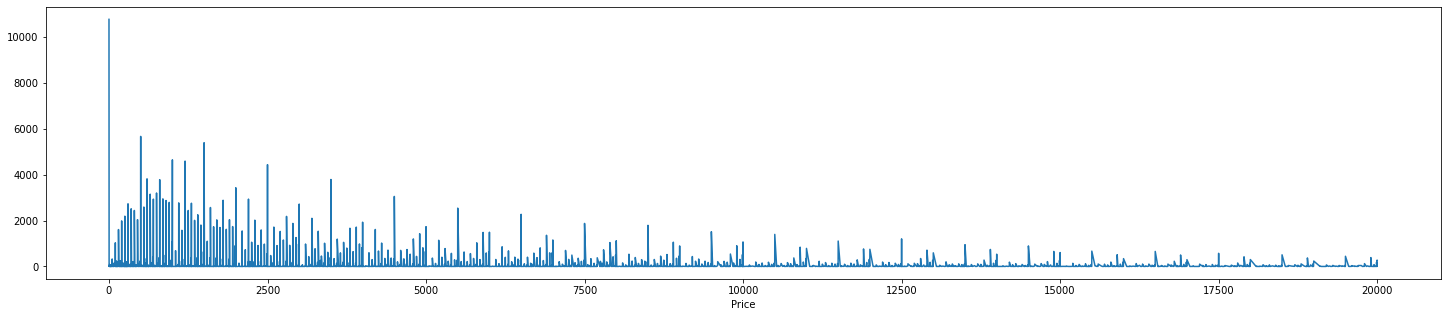

In [ ]:
df.pivot_table(index='Price', values='Brand', aggfunc='count').plot(legend=None, figsize = (25,5));

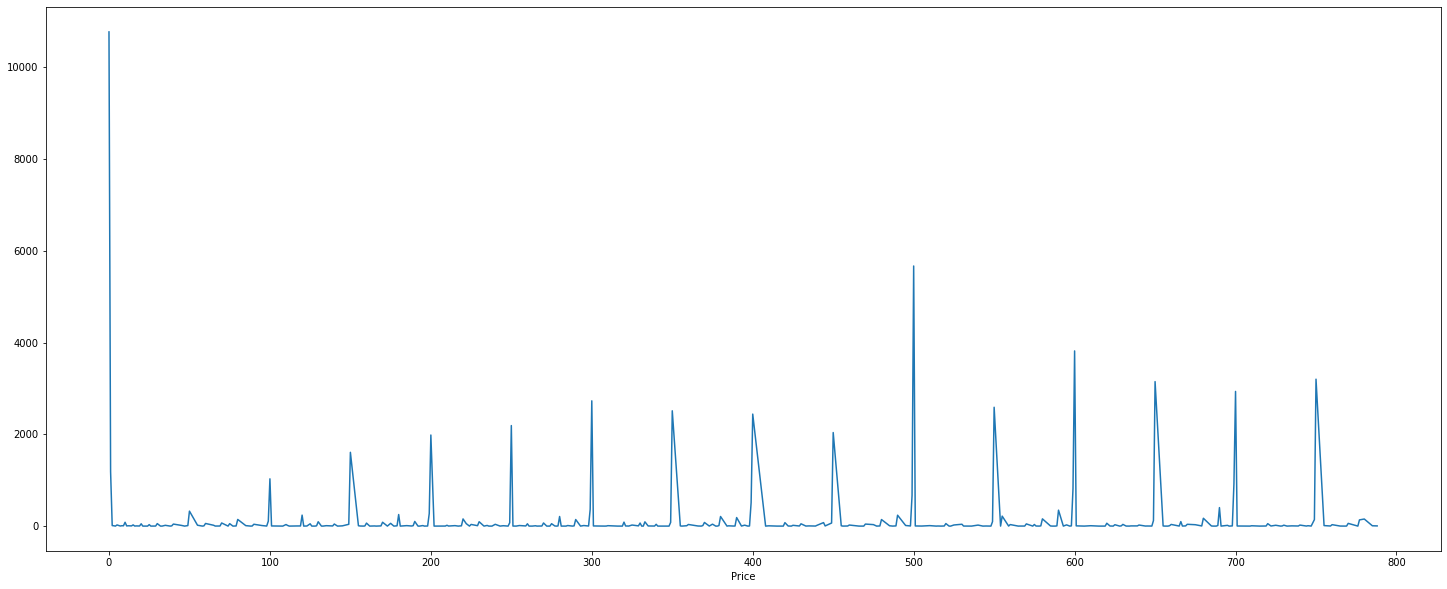

In [ ]:
df.pivot_table(index='Price', values='Brand', aggfunc='count').head(400).plot(legend=None, figsize = (25,10));

In [ ]:
df[df['Price']<100]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,no information,1990,no information,0,corsa,150000,1,petrol,opel,no information,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,no information,150000,11,no information,sonstige_autos,no information,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,no information,2017,manual,0,golf,5000,12,petrol,volkswagen,no information,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,no information,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,no information,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09 00:00:00,0,91301,2016-04-06 22:15:32


In [ ]:
df = df[df['Price'] >= 100]

В данных в целевом признике содержится большое количество значений равных 0. Также содержаться очень маленькие значения 1, 2 и т.д. здесь скорее всего ошибка. Т.к. нам необходимо научить модель прогнозировать цену удаляем все значения меньше 100.

In [ ]:
sorted(df['RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

In [ ]:
df['DateCrawled'].max(), df['DateCreated'].max()

('2016-04-07 14:36:58', '2016-04-07 00:00:00')

In [ ]:
df[(df['RegistrationYear'] < 1910) | (df['RegistrationYear'] > 2016)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,no information,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,no information,2017,manual,125,c4,125000,4,no information,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,no information,2017,manual,80,golf,100000,1,petrol,volkswagen,no information,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,no information,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,no information,2018,manual,64,other,125000,3,no information,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,no information,2017,manual,86,transit,150000,5,gasoline,ford,no information,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,no information,2017,manual,101,a4,150000,9,no information,audi,no information,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,no information,2018,manual,80,fiesta,150000,6,no information,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,no information,2018,no information,0,corsa,150000,0,petrol,opel,no information,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13


In [ ]:
df = df[(df['RegistrationYear'] >= 1910) & (df['RegistrationYear'] <= 2016)]

2019 исправлен на 2016, т.к. max дата скачивания анкеты из базы и дата создания анкеты относятся к 2016 году, все годы ранее 1910 удаляем, т.к. первый автомобиль был изобретен в 1886 году. Предположить, что ретро-автомобили начала 20 века могут присутствовать в объявлениях можно, а 1800 год и ранее - точно ошибка.

In [ ]:
sorted(df['RegistrationYear'].unique())

[1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327321 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        327321 non-null  object
 1   Price              327321 non-null  int64 
 2   VehicleType        327321 non-null  object
 3   RegistrationYear   327321 non-null  int64 
 4   Gearbox            327321 non-null  object
 5   Power              327321 non-null  int64 
 6   Model              327321 non-null  object
 7   Kilometer          327321 non-null  int64 
 8   RegistrationMonth  327321 non-null  int64 
 9   FuelType           327321 non-null  object
 10  Brand              327321 non-null  object
 11  Repaired           327321 non-null  object
 12  DateCreated        327321 non-null  object
 13  NumberOfPictures   327321 non-null  int64 
 14  PostalCode         327321 non-null  int64 
 15  LastSeen           327321 non-null  object
dtypes: int64(7), object(

В данных с годом регистрации автомобиля присутствовали значения, которые нельзя идентифицировать с годом, указанные данные удалены.

In [ ]:
sorted(df['Power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
df[(df['Power']<=10) | (df['Power']>=600)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,no information,1993,manual,0,golf,150000,0,petrol,volkswagen,no information,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,no information,0,ka,5000,0,petrol,ford,no information,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,no information,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,no information,2016,no information,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,no information,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,no information,1995,no information,0,no information,125000,3,petrol,opel,no information,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354346,2016-03-07 17:06:35,2600,no information,2005,auto,0,c_klasse,150000,9,no information,mercedes_benz,no information,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


In [ ]:
df = df[(df['Power']>10) & (df['Power']<600)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295162 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        295162 non-null  object
 1   Price              295162 non-null  int64 
 2   VehicleType        295162 non-null  object
 3   RegistrationYear   295162 non-null  int64 
 4   Gearbox            295162 non-null  object
 5   Power              295162 non-null  int64 
 6   Model              295162 non-null  object
 7   Kilometer          295162 non-null  int64 
 8   RegistrationMonth  295162 non-null  int64 
 9   FuelType           295162 non-null  object
 10  Brand              295162 non-null  object
 11  Repaired           295162 non-null  object
 12  DateCreated        295162 non-null  object
 13  NumberOfPictures   295162 non-null  int64 
 14  PostalCode         295162 non-null  int64 
 15  LastSeen           295162 non-null  object
dtypes: int64(7), object(

В столбце Power присутствовало много строк со значением 0 (вероятно данные не были указаны), также очень маленькие и неправдоподобно большие значения мощности мотора (вероятно в случае очень маленьких значений - числа пропущены, а вслучае очень больших - должна быть запятая). Для более корректного обучения из данных были удалены все строки со значениями менее 10 и более 600.

In [ ]:
columns_drop = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']

In [ ]:
df = df.drop(columns_drop, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295162 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              295162 non-null  int64 
 1   VehicleType        295162 non-null  object
 2   RegistrationYear   295162 non-null  int64 
 3   Gearbox            295162 non-null  object
 4   Power              295162 non-null  int64 
 5   Model              295162 non-null  object
 6   Kilometer          295162 non-null  int64 
 7   RegistrationMonth  295162 non-null  int64 
 8   FuelType           295162 non-null  object
 9   Brand              295162 non-null  object
 10  Repaired           295162 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.0+ MB


Удаляем столбцы -'DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', которые не несут никакой информации для обучения.

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272076 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              272076 non-null  int64 
 1   VehicleType        272076 non-null  object
 2   RegistrationYear   272076 non-null  int64 
 3   Gearbox            272076 non-null  object
 4   Power              272076 non-null  int64 
 5   Model              272076 non-null  object
 6   Kilometer          272076 non-null  int64 
 7   RegistrationMonth  272076 non-null  int64 
 8   FuelType           272076 non-null  object
 9   Brand              272076 non-null  object
 10  Repaired           272076 non-null  object
dtypes: int64(5), object(6)
memory usage: 24.9+ MB


### Подготовка выборок для обучения моделей

In [ ]:
target = df['Price']
features = df.drop('Price', axis=1)

In [ ]:
target.shape, features.shape

((272076,), (272076, 10))

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.4,
                                                                            random_state=12345)

In [ ]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((163245, 10), (108831, 10), (163245,), (108831,))

In [ ]:
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test,
                                                                            test_size=0.5,
                                                                            random_state=12345)

In [ ]:
features_valid.shape, features_test.shape, target_valid.shape, target_test.shape

((54416, 10), (54415, 10), (54416,), (54415,))

In [ ]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType','Repaired', 'Model','Brand']

In [ ]:
features_train[ohe_columns]

,VehicleType,Gearbox,FuelType,Repaired,Model,Brand
85413,bus,manual,petrol,yes,other,mitsubishi
311635,sedan,manual,petrol,no information,e_klasse,mercedes_benz
105563,no information,manual,petrol,no information,astra,opel
296792,sedan,manual,petrol,no information,golf,volkswagen
258889,wagon,manual,petrol,no information,mondeo,ford
...,...,...,...,...,...,...
200453,sedan,manual,gasoline,no,toledo,seat
58645,small,manual,petrol,no,other,mercedes_benz
106806,sedan,no information,petrol,no,other,daewoo
95275,small,manual,petrol,no,other,suzuki


In [ ]:
encoder_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')#drop='first'

In [ ]:
encoder_ohe.fit(features_train[ohe_columns])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
def func_ohe(semple):
    semple[encoder_ohe.get_feature_names()] = encoder_ohe.transform(semple[ohe_columns])
    semple = semple.drop(ohe_columns, axis=1)
    return semple

In [ ]:
features_train = func_ohe(features_train)

In [ ]:
features_train

,RegistrationYear,Power,Kilometer,RegistrationMonth,x0_bus,x0_convertible,x0_coupe,x0_no information,x0_other,x0_sedan,...,x5_seat,x5_skoda,x5_smart,x5_sonstige_autos,x5_subaru,x5_suzuki,x5_toyota,x5_trabant,x5_volkswagen,x5_volvo
85413,2002,98,150000,11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311635,1993,136,150000,3,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105563,2016,116,20000,2,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296792,2001,75,150000,10,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
258889,2001,85,150000,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200453,2005,140,150000,3,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58645,2001,125,125000,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106806,1997,95,80000,3,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95275,1999,85,125000,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
features_valid = func_ohe(features_valid)

In [ ]:
features_valid

,RegistrationYear,Power,Kilometer,RegistrationMonth,x0_bus,x0_convertible,x0_coupe,x0_no information,x0_other,x0_sedan,...,x5_seat,x5_skoda,x5_smart,x5_sonstige_autos,x5_subaru,x5_suzuki,x5_toyota,x5_trabant,x5_volkswagen,x5_volvo
117379,1994,115,150000,11,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47866,1968,50,5000,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139646,2000,60,150000,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19398,2005,178,150000,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
207306,2000,105,150000,8,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353801,2003,105,150000,11,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
171429,2008,143,125000,8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247628,2009,140,150000,7,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1878,2007,60,90000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
features_test = func_ohe(features_test)

In [ ]:
features_test

,RegistrationYear,Power,Kilometer,RegistrationMonth,x0_bus,x0_convertible,x0_coupe,x0_no information,x0_other,x0_sedan,...,x5_seat,x5_skoda,x5_smart,x5_sonstige_autos,x5_subaru,x5_suzuki,x5_toyota,x5_trabant,x5_volkswagen,x5_volvo
210845,2003,218,150000,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41422,2000,143,150000,7,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73077,1998,101,150000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41608,2005,60,90000,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1608,2005,116,150000,6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330350,1990,99,150000,2,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97298,2009,122,70000,9,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35494,2001,272,150000,12,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118827,2002,75,100000,7,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Данные содержали 16 столбцов и 354369 строк, в строках присутствовали пропуски. Т.к. все пропущенные данные являлись категорийными и восстановить их значения возможности не было - пропуски были заполнены категорией 'no information'.
В целевом признаке содержалось большое количество значений равных 0. Также присутствовали очень маленькие значения 1, 2 и т.д. Т.к. нам необходимо научить модель прогнозировать цену были удалены все значения меньше 100.
В данных с годом регистрации автомобиля присутствовали значения, которые нельзя идентифицировать с годом, они были удалены.
В столбце Power присутствовало много строк со значением 0, также очень маленькие и неправдоподобно большие значения мощности. Для более корректного обучения были удалены все строки со значениями менее 10 и более 600.
Были удалены столбцы -'DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', которые не несут никакой информации для обучения. Данные были разбиты на обучающую, валидационную и тестовую выборки. Категориальные признаки были закодированы.

## Обучение моделей

**LGBMRegressor**

In [ ]:
estimators = [50, 150, 300, 650]
best_model_lgbmr = None
best_result_lgbmr = 2500
n_estimators_lgbmr = 0
max_depth_lgbmr = 0
for est in estimators:
    for depth in range(11, 16):
        model_lgbmr = lgb.LGBMRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        model_lgbmr.fit(features_train, target_train, verbose=25)
        predict_lgbmr = model_lgbmr.predict(features_valid)
        result_lgbmr = mean_squared_error(target_valid, predict_lgbmr)**0.5
        if result_lgbmr < best_result_lgbmr:
            best_model_lgbmr = model_lgbmr
            best_result_lgbmr = result_lgbmr
            n_estimators_lgbmr = est
            max_depth_lgbmr = depth
print("RMSE", best_result_lgbmr, ', n_estimators =', n_estimators_lgbmr, ', max_depth', max_depth_lgbmr)

RMSE 1572.5297863985313 , n_estimators = 650 , max_depth 12


In [ ]:
start = time.time()
model_lgbmr = lgb.LGBMRegressor(n_estimators=n_estimators_lgbmr, max_depth=max_depth_lgbmr, random_state=12345)
model_lgbmr.fit(features_train, target_train, verbose=25)
end = time.time()
fit_time_lgbmr = end - start
print('время обучения', fit_time_lgbmr)
start2 = time.time()
predict_lgbmr = model_lgbmr.predict(features_valid)
end2 = time.time()
predict_time_lgbmr = end2 - start2
print('время предсказания', predict_time_lgbmr)
rmse_lgbmr = mean_squared_error(target_valid, predict_lgbmr)**0.5
print("RMSE", rmse_lgbmr)

время обучения 22.300128936767578
время предсказания 2.5262386798858643
RMSE 1572.5297863985313


**CatBoostRegressor**

In [ ]:
best_model_cb = None
best_result_cb = 2500
iterations = 0
depth = 0
for iteration in range(50, 351, 100):
    for depth in range(9, 13):
        model_cb = CatBoostRegressor(depth=depth, iterations=iteration, random_state=12345)
        model_cb.fit(features_train, target_train, verbose=100)
        predict_cb = model_cb.predict(features_valid)
        result_cb = mean_squared_error(target_valid, predict_cb)**0.5
        if result_cb < best_result_cb:
            best_model_cb = model_cb
            best_result_cb = result_cb
            iterations = iteration
            depth = depth
print("RMSE", best_result_cb, ', iterations =', iterations, ', depth', depth)

Learning rate set to 0.5
0:	learn: 3148.4511651	total: 88.6ms	remaining: 4.34s
49:	learn: 1564.0968476	total: 1.49s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3107.6724790	total: 47.1ms	remaining: 2.31s
49:	learn: 1538.6806779	total: 2.27s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3088.8470918	total: 62.9ms	remaining: 3.08s
49:	learn: 1512.7896250	total: 2.96s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3081.9952343	total: 81.7ms	remaining: 4s
49:	learn: 1477.2629573	total: 4.13s	remaining: 0us
Learning rate set to 0.428199
0:	learn: 3330.3733482	total: 30.6ms	remaining: 4.56s
100:	learn: 1494.0830186	total: 2.82s	remaining: 1.37s
149:	learn: 1439.3417493	total: 4.19s	remaining: 0us
Learning rate set to 0.428199
0:	learn: 3295.9151353	total: 44.2ms	remaining: 6.58s
100:	learn: 1459.2489969	total: 4.63s	remaining: 2.25s
149:	learn: 1400.4368259	total: 6.83s	remaining: 0us
Learning rate set to 0.428199
0:	learn: 3280.0529026	total: 56ms	remaining: 8.34s
100:	learn: 1

In [ ]:
start = time.time()
model_cb = CatBoostRegressor(depth=depth, iterations=iterations, random_state=12345)
model_cb.fit(features_train, target_train, verbose=50)
end = time.time()
fit_time_cb = end - start
print('время обучения', fit_time_cb)
start2 = time.time()
predict_cb = model_cb.predict(features_valid)
end2 = time.time()
predict_time_cb = end2 - start2
print('время предсказания', predict_time_cb)
rmse_cb = mean_squared_error(target_valid, predict_cb)**0.5
print('RMSE:', rmse_cb)

Learning rate set to 0.215021
0:	learn: 3912.8017430	total: 80ms	remaining: 27.9s
50:	learn: 1577.3762208	total: 4.11s	remaining: 24.1s
100:	learn: 1485.5685089	total: 8.15s	remaining: 20.1s
150:	learn: 1425.9598799	total: 12.2s	remaining: 16.1s
200:	learn: 1376.9094974	total: 16.3s	remaining: 12.1s
250:	learn: 1341.4307713	total: 20.4s	remaining: 8.04s
300:	learn: 1306.7578236	total: 24.5s	remaining: 3.99s
349:	learn: 1279.9912762	total: 28.6s	remaining: 0us
время обучения 30.589542388916016
время предсказания 0.11799836158752441
RMSE: 1559.7212039048775


**RandomForestRegressor**

In [ ]:
best_model_rf = None
best_result_rf = 2500
n_estimators = 0
max_depth = 0
for est in range(30, 51, 10):
    for depth in range(14, 17):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est,
                                        max_depth=depth)
        model_rf.fit(features_train, target_train)
        predict_rf = model_rf.predict(features_valid)
        result = mean_squared_error(target_valid, predict_rf)**0.5
        if result < best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result
            n_estimators = est
            max_depth = depth
print("RMSE", best_result_rf, ', n_estimators =', n_estimators, ', max_depth', max_depth)

RMSE 1679.9804184438353 , n_estimators = 50 , max_depth 16


In [ ]:
start = time.time()
model_rf = RandomForestRegressor(random_state=12345, n_estimators=n_estimators, max_depth=max_depth)
model_rf.fit(features_train, target_train)
end = time.time()
fit_time_rf = end - start
print('время обучения', fit_time_rf)
start2 = time.time()
predict_rf = model_rf.predict(features_valid)
end2 = time.time()
predict_time_rf = end2 - start2
print('время предсказания', predict_time_rf)
rmse_rf = mean_squared_error(target_valid, predict_rf)**0.5
print('RMSE:', rmse_rf)

время обучения 92.32510900497437
время предсказания 0.5732195377349854
RMSE: 1679.9804184438353


**LinearRegression**

In [ ]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_valid)
print('RMSE:', mean_squared_error(target_valid, predict_lr)**0.5)

RMSE: 2582.488439684079


У модели LinearRegression качество хуже рекомендованого, поэтому ее далее в анализе не будем использовать.

## Анализ моделей

In [ ]:
data = pd.DataFrame([['LGBMRegressor', rmse_lgbmr, fit_time_lgbmr, predict_time_lgbmr],
                    ['CatBoostRegressor', rmse_cb, fit_time_cb, predict_time_cb],
                    ['RandomForestRegressor',rmse_rf, fit_time_rf, predict_time_rf]],
                    columns=['модель', 'rmse', 'время обучения', 'время предсказания'])

In [ ]:
data

,модель,rmse,время обучения,время предсказания
0,LGBMRegressor,1572.529786,22.300129,2.526239
1,CatBoostRegressor,1559.721204,30.589542,0.117998
2,RandomForestRegressor,1679.980418,92.325109,0.573220


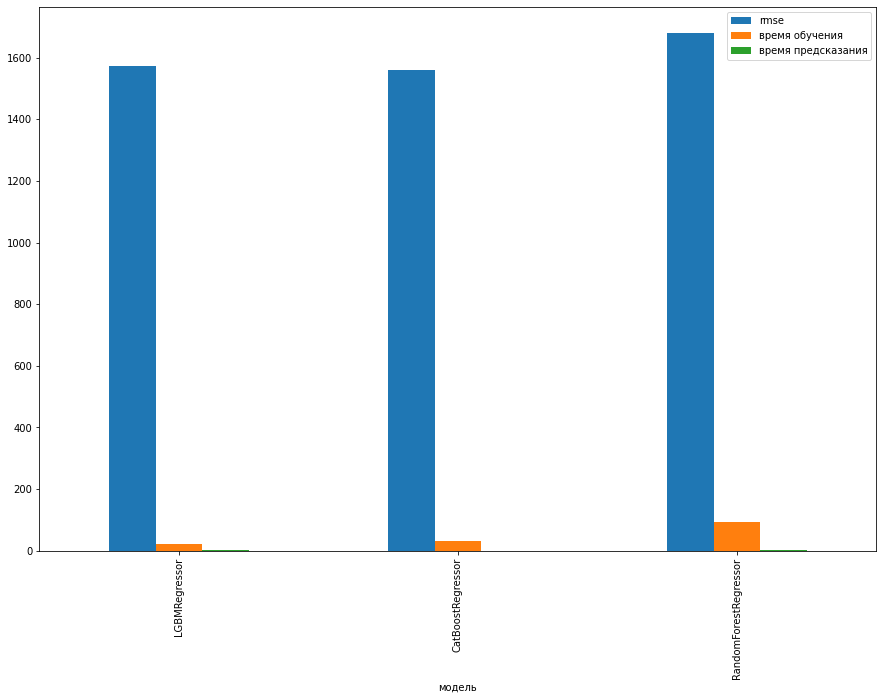

In [ ]:
data.plot.bar(x='модель', xlabel='модель', figsize=(15,10));

Лучшее время предсказания и точность результата у модели CatBoostRegressor, а время обучения лучше у LGBMRegressor. Т.к. стоит задача быстро прогнозировать рыночную стоимость автомобиля, то время предсказания и точность результата являются более значимыми параметрами, тем более, что разница во времени обучения у двух моделей не сильно отличается. Т.о. далее в качестве лучшей модели будет проверена на тестовой выборке CatBoostRegressor.

**Проверка лучшей модели на тестовой выборке**

In [ ]:
start = time.time()
model_cb.fit(features_train, target_train, verbose=50)
end = time.time()
fit_time = end - start
print('время обучения', fit_time)
start2 = time.time()
predict = model.predict(features_test)
end2 = time.time()
predict_time = end2 - start2
print('время предсказания', predict_time)
rmse = mean_squared_error(target_test, predict)**0.5
print('RMSE:', rmse)

Learning rate set to 0.215021
0:	learn: 3912.8017430	total: 83.6ms	remaining: 29.2s
50:	learn: 1577.3762208	total: 4.2s	remaining: 24.6s
100:	learn: 1485.5685089	total: 8.43s	remaining: 20.8s
150:	learn: 1425.9598799	total: 12.6s	remaining: 16.6s
200:	learn: 1376.9094974	total: 16.7s	remaining: 12.4s
250:	learn: 1341.4307713	total: 20.8s	remaining: 8.21s
300:	learn: 1306.7578236	total: 24.8s	remaining: 4.03s
349:	learn: 1279.9912762	total: 28.8s	remaining: 0us
время обучения 30.795867204666138
время предсказания 0.11187934875488281
RMSE: 1532.0861343847828


Для проекта были использованы исторические данные: технические характеристики, комплектации и цены автомобилей. В данных присутствовали пропуски, которые были заполнены категорией 'no information'.
В целевом признаке содержалось большое количество значений равных 0. Также присутствовали очень маленькие значения 1, 2 и т.д., все значения меньше 100 были удалены.
В данных с годом регистрации автомобиля присутствовали значения, которые нельзя идентифицировать с годом, они были удалены.
В столбце Power присутствовало много строк со значением 0, также очень маленькие и неправдоподобно большие значения мощности,  все строки со значениями менее 10 и более 600 были удалены.
Были удалены столбцы -'DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'. Данные были разбиты на обучающую, валидационную и тестовую выборки. Категориальные признаки были закодированы.
Были обучены модели LinearRegression, LGBMRegressor, CatBoostRegressor, RandomForestRegressor. Для определения качества моделей использовалась метрика RMSE. LinearRegression показала очень плохие значения метрики (ниже рекомендуемых) и более не рассматривалась. Результат  RandomForestRegressor RMSE: 1679.9804184438353 при n_estimators = 50 и max_depth 16.
Лучшие показатели были получены у моделей LGBMRegressor при n_estimators=650, max_depth=12, время обучения 21.250996112823486,
время предсказания 3.225551128387451, RMSE 1572.5297863985313 и CatBoostRegressor при depth=12, iterations=350, время обучения 38.728684425354004, время предсказания 0.16374874114990234, RMSE: 1559.7212039048775. Однако, рассматривая все показатели и  учитывая тот факт, что качество предсказания и время предсказания меньше у модели CatBoostRegressor, именно данная модель была проверена на тестовой выборке. Результаты проверки - время обучения 30.795867204666138, время предсказания 0.11187934875488281, RMSE: 1532.0861343847828.
Т.о. заказчику для предсказания рыночной стоимости автомобиля можно рекомендовать модель CatBoostRegressor (depth=12, iterations=350).